# Exploraty data analyses

Comentar brevemente sobre o problema e depois sobre o que foi desenvolvido.

### Summary

1. [Imports](#Imports)
2. [Data pre processing](#Data-pre-processing)
    - Accessing the data
    - Feature engineering: format correction, feature creation, sample balancement, null values correction
    - Outliers
    - Distribution analyses
    
    
3. [Data processing](#Data-processing)
    - Descriptive statistics analysis for each class (Exited/Not exited)
    - Correlation analyses
    
    
4. [Data split](#Data-split)
5. [Modeling](#Modeling)
6. [Deploy](#Deploy): saving results

## Imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import kstest, shapiro 
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import KFold, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, roc_auc_score

import pickle

## Data pre processing

### Accessing the data

In [2]:
data = pd.read_csv('Churn_Modelling.csv').drop('RowNumber', axis=1)
data.head(3)

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1


In [3]:
qualitatives = ['CustomerId', 'Surname', 'Geography', 'Gender', 'HasCrCard', 'IsActiveMember', 'Exited']
quantitatives = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']

### Feature engineering

#### Format correction

In [4]:
data = pd.concat([data.drop('Geography', axis=1), pd.get_dummies(data['Geography'], prefix='Geography')], axis=1) 

*Geography* é uma coluna categorica textual. Dessa forma, foi necessário **separar uma coluna para cada valor possível dessa varíavel**. O resultado foi a criação de novas três colunas: 'Geography_France', 'Geography_Germany' e 'Geography_Spain'.

In [5]:
data['Gender_male'] = data['Gender'].apply(lambda x:1 if x == 'Male' else 0)

*Gender* também é uma coluna categórica textual com os valores possíveis 'Male' e 'Female'. Os valores textuais 'Male' foram substituidos por 1, enquanto 'Female' por 0. A coluna foi renomeada para *Gender_male* com intuito de tornar a mudança mais intuitiva.

#### Feature creation

In [6]:
surnames = data['Surname'].values

def surname_freq(surname):
    cont = 0
    
    for name in surnames:
        if name == surname:
            cont += 1
            
    return cont

data['Surname_freq'] = data['Surname'].apply(surname_freq)
data['Has_parent'] = data['Surname_freq'].apply(lambda x:1 if x > 1 else 0)

Como *surnames* é uma característica textual do indivíduo, ela não fornece muita informação a priori. Dessa forma, tal coluna foi processada e duas características novas foram criadas: 
- Surname_freq: frequência que aparece o sobrenome
- Has_parent: se o cliente tem parente na empresa (Surname_freq > 1)

In [7]:
data = data[['CreditScore', 'Gender_male', 'Age', 'Tenure', 'Balance',
             'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary',
             'Geography_France', 'Geography_Germany', 'Geography_Spain',
             'Surname_freq', 'Has_parent', 'Exited']]

Ordem das colunas foi apenas reajustada para que *Exited* se mantivésse em último no conjunto.

In [8]:
qualitatives = ['CustomerId', 'Surname', 'Geography_France', 'Geography_Germany',
                'Geography_Spain', 'Gender_male', 'HasCrCard', 'IsActiveMember', 
                'Has_parent', 'Exited']

quantitatives = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 
                 'EstimatedSalary', 'Surname_freq']

#### Sample balancement

In [9]:
display(data['Exited'].value_counts(normalize=True).to_frame())

,Exited
0,0.7963
1,0.2037


Como pôde ser visualizado, existem muito mais casos no conjunto de não saída do que de saída, o que pode gerar um modelo tendencioso para casos de não saída. 

Dessa forma, será realizada então uma sub amostragem aleatória dessa amostra (para casos de não saída) para que haja balanceamento entre os possíveis valores. 

In [10]:
np.random.seed(7)

i = data.query('Exited == 0').index
n = len(data.query('Exited == 1').index.to_list()) + 1

i_sampled = np.random.choice(i, n)

Com o procedimento acima, foi feita uma subamostragem a amostra total de valores *Exited* iguais a 0. Abaixo será avaliado se a subamostra representa aceitavelmente a amostra original. Cada coluna da nova amostra será comparada com cada coluna da amostra total através do teste de distribuição amostral KS.

In [11]:
original = data.loc[i]
sampled = data.loc[i_sampled]

for column in original.columns:
    print(kstest(original[column].values, sampled[column].values))

KstestResult(statistic=0.01850295842018107, pvalue=0.6268346939267916)
KstestResult(statistic=0.008734891020133969, pvalue=0.9995686023232194)
KstestResult(statistic=0.014679275358050118, pvalue=0.8693319727498474)
KstestResult(statistic=0.014443272165167236, pvalue=0.8814529409950971)
KstestResult(statistic=0.01571898341901954, pvalue=0.810278847804602)
KstestResult(statistic=0.002671087834226428, pvalue=1.0)
KstestResult(statistic=0.0033549425168933303, pvalue=1.0)
KstestResult(statistic=0.002553086237784986, pvalue=1.0)
KstestResult(statistic=0.01807673542144193, pvalue=0.6557818955543555)
KstestResult(statistic=0.0014988975631530371, pvalue=1.0)
KstestResult(statistic=0.01579606957941027, pvalue=0.8055855007797088)
KstestResult(statistic=0.017294967142563306, pvalue=0.7086826623303911)
KstestResult(statistic=0.014726968953687547, pvalue=0.866821052450195)
KstestResult(statistic=0.00807297292667498, pvalue=0.9999087527600012)
KstestResult(statistic=0.0, pvalue=1.0)


Como o resultado foi aceitável, o conjunto de dados será balanceado usando a amostra original Exited == 1 e a subamostra Exited == 0.

In [12]:
data = pd.concat([data.query('Exited == 1'), data.loc[i_sampled]], axis=0).sort_index().reset_index(drop=True)

display(data['Exited'].value_counts(normalize=True).to_frame())

,Exited
0,0.500123
1,0.499877


Dessa forma, tem-se um conjunto de dados balanceado 50/50.

#### Null values correction
O conjunto obtido até aqui não apresenta dados nulos.

### Outliers

#### Cases detection

<AxesSubplot:title={'center':'CreditScore'}>

<AxesSubplot:title={'center':'Age'}>

<AxesSubplot:title={'center':'Tenure'}>

<AxesSubplot:title={'center':'Balance'}>

<AxesSubplot:title={'center':'NumOfProducts'}>

<AxesSubplot:title={'center':'EstimatedSalary'}>

<AxesSubplot:title={'center':'Surname_freq'}>

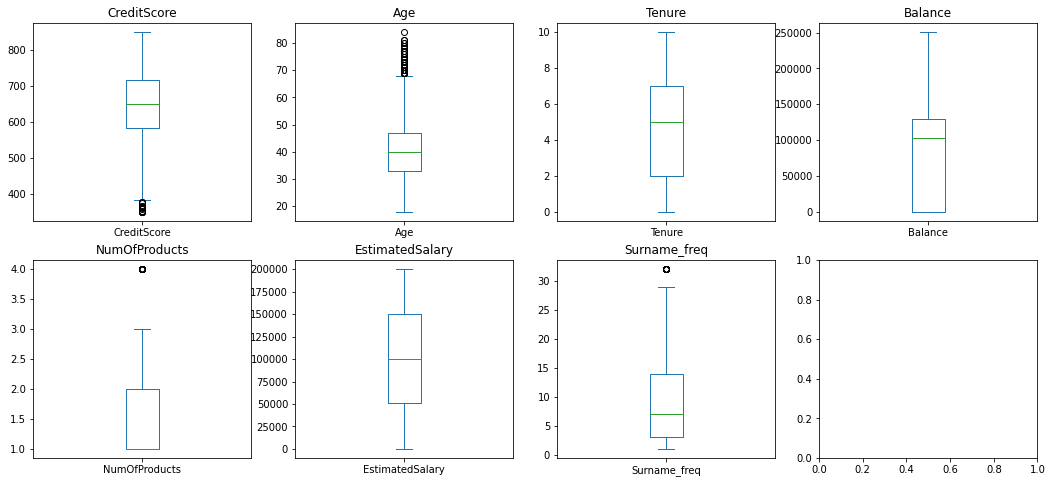

In [13]:
i = 0
j = 0

fig, ax = plt.subplots(2, 4, figsize=(18, 8))

for column in quantitatives:
    ax[i][j].set_title(column)
    display(data[column].plot(kind='box', ax=ax[i][j]))
    j += 1

    if j%4==0:
        j = 0
        i += 1

### Distribution analyses

In [14]:
#Identificação de normalidade
for column in quantitatives:
    print(f'\n {column}: p-value = {shapiro(data[column])[1]}')


 CreditScore: p-value = 3.2254669855152907e-12

 Age: p-value = 3.160709070211171e-24

 Tenure: p-value = 6.564754975526383e-36

 Balance: p-value = 0.0

 NumOfProducts: p-value = 0.0

 EstimatedSalary: p-value = 3.307495112982142e-34

 Surname_freq: p-value = 9.542842542052004e-43


Através do teste de Normalidade Shapiro, pode-se perceber que não há hevidências suficientes para considerar as variáveis quantitativas como variáveis de distribuição normal. 

In [15]:
#Normalização
scaler = MinMaxScaler()

data[quantitatives] = scaler.fit_transform(data[quantitatives])

Como as colunas não são de distribuição normal, foi adotado como método de normalização dos dados a minimalização com máximos e mínimos.

## Data processing

In [16]:
data.query('Exited == 0').describe()

,CreditScore,Gender_male,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Surname_freq,Has_parent,Exited
count,2038.000000,2038.000000,2038.000000,2038.000000,2038.000000,2038.000000,2038.000000,2038.000000,2038.000000,2038.000000,2038.000000,2038.000000,2038.000000,2038.000000,2038.0
mean,0.609070,0.563788,0.289804,0.496124,0.295053,0.180242,0.710500,0.552012,0.498443,0.529441,0.228656,0.241904,0.256070,0.850343,0.0
std,0.191201,0.496036,0.151819,0.284745,0.249418,0.169405,0.453641,0.497409,0.291684,0.499255,0.420070,0.428341,0.220529,0.356822,0.0
min,0.130000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000476,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
25%,0.474000,0.000000,0.196970,0.200000,0.000000,0.000000,0.000000,0.000000,0.250112,0.000000,0.000000,0.000000,0.064516,1.000000,0.0
50%,0.614000,1.000000,0.272727,0.500000,0.367661,0.333333,1.000000,1.000000,0.485148,1.000000,0.000000,0.000000,0.193548,1.000000,0.0
75%,0.735500,1.000000,0.348485,0.700000,0.503688,0.333333,1.000000,1.000000,0.747000,1.000000,0.000000,0.000000,0.419355,1.000000,0.0
max,1.000000,1.000000,0.954545,1.000000,0.882959,0.666667,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0


In [17]:
data.query('Exited == 1').describe()

,CreditScore,Gender_male,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Surname_freq,Has_parent,Exited
count,2037.000000,2037.000000,2037.000000,2037.000000,2037.000000,2037.000000,2037.000000,2037.000000,2037.000000,2037.000000,2037.000000,2037.000000,2037.000000,2037.000000,2037.0
mean,0.590703,0.440844,0.406636,0.493274,0.363130,0.158403,0.699067,0.360825,0.507374,0.397644,0.399607,0.202749,0.259046,0.851743,1.0
std,0.200643,0.496610,0.147902,0.293611,0.232608,0.267174,0.458776,0.480358,0.289621,0.489531,0.489938,0.402146,0.225607,0.355442,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
25%,0.456000,0.000000,0.303030,0.200000,0.152811,0.000000,0.000000,0.000000,0.259534,0.000000,0.000000,0.000000,0.064516,1.000000,1.0
50%,0.592000,0.000000,0.409091,0.500000,0.435831,0.000000,1.000000,0.000000,0.512351,0.000000,0.000000,0.000000,0.193548,1.000000,1.0
75%,0.732000,1.000000,0.500000,0.800000,0.523851,0.333333,1.000000,1.000000,0.762212,1.000000,1.000000,0.000000,0.419355,1.000000,1.0
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.999187,1.000000,1.000000,1.000000,1.000000,1.000000,1.0


Inferências estatísticas aqui

In [18]:
data.corr()

,CreditScore,Gender_male,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Surname_freq,Has_parent,Exited
CreditScore,1.000000,0.012491,-0.017975,0.008404,0.008494,0.001733,-0.004339,0.023523,-0.041584,-0.001705,-0.008672,0.011725,-0.005810,-0.024392,-0.046819
Gender_male,0.012491,1.000000,-0.023413,0.027584,0.019549,-0.038600,0.016468,0.033171,-0.016763,0.003047,-0.003155,-0.000132,0.014705,-0.011145,-0.122945
Age,-0.017975,-0.023413,1.000000,-0.017231,0.032150,-0.022886,-0.013844,0.012590,-0.017317,-0.053421,0.059999,-0.002909,-0.011353,-0.015790,0.363234
Tenure,0.008404,0.027584,-0.017231,1.000000,0.014831,0.018792,0.008416,-0.030740,0.009940,-0.000659,0.018623,-0.019998,0.006231,0.029040,-0.004927
Balance,0.008494,0.019549,0.032150,0.014831,1.000000,-0.186626,-0.015259,0.001023,0.008558,-0.263843,0.413333,-0.144976,0.024762,0.012935,0.139793
NumOfProducts,0.001733,-0.038600,-0.022886,0.018792,-0.186626,1.000000,-0.014342,0.044864,0.031395,0.015704,-0.033223,0.018253,-0.000818,0.005481,-0.048771
HasCrCard,-0.004339,0.016468,-0.013844,0.008416,-0.015259,-0.014342,1.000000,-0.026895,-0.022245,0.016895,0.019559,-0.042095,-0.019289,0.004238,-0.012533
IsActiveMember,0.023523,0.033171,0.012590,-0.030740,0.001023,0.044864,-0.026895,1.000000,-0.023664,0.026459,-0.010875,-0.019593,-0.011528,-0.020673,-0.191917
EstimatedSalary,-0.041584,-0.016763,-0.017317,0.009940,0.008558,0.031395,-0.022245,-0.023664,1.000000,-0.002300,-0.011844,0.015979,0.021592,0.028279,0.015366
Geography_France,-0.001705,0.003047,-0.053421,-0.000659,-0.263843,0.015704,0.016895,0.026459,-0.002300,1.000000,-0.629079,-0.497043,-0.026501,-0.029882,-0.132148


In [19]:
data.corr()['Exited'].sort_values().to_frame()

,Exited
IsActiveMember,-0.191917
Geography_France,-0.132148
Gender_male,-0.122945
NumOfProducts,-0.048771
Geography_Spain,-0.047082
CreditScore,-0.046819
HasCrCard,-0.012533
Tenure,-0.004927
Has_parent,0.001965
Surname_freq,0.006672


Comentar sobre as principais correlações (usar gráficos aqui pode ser uma boa abordagem)

### Data split

In [20]:
X, y = data.drop('Exited', axis=1), data['Exited']

### Modeling

In [21]:
kf = KFold(n_splits=5)

rps = []
rns = []
cms = []
rocs = []

for train_index, test_index in kf.split(X):
    X_train, y_train = X.iloc[train_index], y.iloc[train_index]
    X_test, y_test = X.iloc[test_index], y.iloc[test_index]
    
    model = RandomForestClassifier(random_state=7)
    model.fit(X_train, y_train)
    
    y_hat = model.predict(X_test)

    cm = confusion_matrix(y_true=y_test, y_pred=y_hat)
    cms.append(cm)
    
    right_positive_rate = cm[1][1] / (cm[1][0] + cm[1][1])
    rps.append(right_positive_rate)
    
    right_negative_rate = cm[0][0] / (cm[0][0] + cm[0][1])
    rns.append(right_negative_rate)
    
    roc = roc_auc_score(y_true=y_test, y_score=model.predict_proba(X_test)[:, 1]) 
    rocs.append(roc)
    
rps = np.array(rps)
rns = np.array(rns)
rocs = np.array(rocs)

Comentar sobre o procedimento utilzado, sobre o KFold (número de dobras).

### Evaluation

In [22]:
print('Taxa de acerto para casos positivos: %.2f%% +- %.2f%%' % (rps.mean()*100, rps.std()*100))
print('Taxa de acerto para casos negativos: %.2f%% +- %.2f%%' % (rns.mean()*100, rns.std()*100))
print('\nROC AUC Score: %.4f +- %.4f' % (rocs.mean(), rocs.std()))

Taxa de acerto para casos positivos: 75.66% +- 1.95%
Taxa de acerto para casos negativos: 78.83% +- 2.27%

ROC AUC Score: 0.8506 +- 0.0111


Comentar resultados aqui

In [23]:
model.fit(X, y)

RandomForestClassifier(random_state=7)

## Deploy

Comentar sobre os processos de deploy que serão realizados.

### Saving results

#### Scaler save

In [24]:
scaler_file = open('Scalers/min_max_quantitatives.pkl', 'wb')
pickle.dump(scaler, scaler_file)
scaler_file.close()

#### Model save

In [25]:
model_file = open('Scalers/min_max_quantitatives.pkl', 'wb')
pickle.dump(model, model_file)
model_file.close()